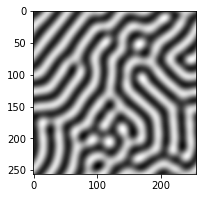

In [10]:
import scipy.io as sio
import numpy as np
import sys
import matplotlib.pyplot as plt
sys.path.append('/Users/edwardmcdugald/Research/convection_patterns_wip/code/ml_experiments')
from myPDEFINDv2 import *
# sys.path.append('/Users/edwardmcdugald/Research/convection_patterns_wip/code/numerics')
# import convection_patterns_v2 as cp
#
# cp.solveSH(20*np.pi,20*np.pi,256,256,.1,100,"SHAutoEncode_3",Rscale=.5,
#             beta=.45,amplitude=.1,init_flag=1,energy=False)
data = sio.loadmat("/Users/edwardmcdugald/Research/convection_patterns_wip/code/data/SHAutoEncode_3.mat")
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3,3))
ax.imshow(data['uu'][500,:,:])


In [11]:
tt = data['tt'][0][100:] #TVALUES, EXCLUDING FIRST ONE
xx = data['xx']
yy = data['yy']
U = data['uu'][101:1001,:,:] #TAKE LAST 1000 U surfaces
dt = data['tt'][0][1]-data['tt'][0][0]
Ut = BackwardDiff(U,data['uu'][100:1000,:,:],dt) #Compute U derivatives
n_samples = len(tt)
N = len(xx)*len(yy)

#subsampling by factor of 2
training_data = {'tt': tt[0:700],
                     'xx': xx[::2].T,
                     'yy': yy[::2].T,
                     'U': U[0:700,::2,::2],
                     'Ut': Ut[0:700,::2,::2]}
val_data = {'tt': tt[700:800],
                'xx': xx[::2].T,
                'yy': yy[::2].T,
                'U': U[700:800,::2,::2],
                'Ut': Ut[700:800,::2,::2]}
test_data = {'tt': tt[800:900],
                 'xx': xx[::2].T,
                 'yy': yy[::2].T,
                 'U': U[800:900,::2,::2],
                 'Ut': Ut[800:900,::2,::2]}

In [12]:
import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model


In [13]:
u_train = training_data['U']
u_test = test_data['U']
u_val = val_data['U']
u_train = u_train.astype('float32')
u_test = u_test.astype('float32')
u_val = u_val.astype('float32')
conv_u_train = u_train[..., tf.newaxis]
conv_u_test = u_test[..., tf.newaxis]
conv_u_val = u_val[..., tf.newaxis]
print(conv_u_train.shape)
print(conv_u_test.shape)
print(conv_u_val.shape)

(700, 128, 128, 1)
(100, 128, 128, 1)
(100, 128, 128, 1)


In [5]:
class ConvAutoencoder(Model):
  def __init__(self):
    super(ConvAutoencoder, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(128, 128,1)),
      layers.Conv2D(16, (3, 3), activation='linear', padding='same', strides=2),
      layers.Conv2D(8, (3, 3), activation='sigmoid', padding='same', strides=2),
      layers.Conv2D(1, (3, 3), activation='relu', padding='same')])

    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(1, (3, 3), activation='linear', padding='same'),
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='sigmoid', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Dense(100,activation='relu'),
      layers.Conv2D(1, kernel_size=(3, 3), activation='linear', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

conv_autoencoder = ConvAutoencoder()


2022-12-06 21:50:00.114056: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
conv_autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
conv_autoencoder.fit(conv_u_train, conv_u_train,
                epochs=10,
                shuffle=False,
                validation_data=(conv_u_test, conv_u_test))

Epoch 1/10
22/22 [==============================] - 39s 2s/step - loss: 0.0319 - val_loss: 0.0267
Epoch 2/10
22/22 [==============================] - 27s 1s/step - loss: 0.0231 - val_loss: 0.0230
Epoch 3/10
22/22 [==============================] - 33s 2s/step - loss: 0.0241 - val_loss: 0.0227
Epoch 4/10
22/22 [==============================] - 31s 1s/step - loss: 0.0236 - val_loss: 0.0224
Epoch 5/10
22/22 [==============================] - 33s 2s/step - loss: 0.0229 - val_loss: 0.0225
Epoch 6/10
22/22 [==============================] - 28s 1s/step - loss: 0.0223 - val_loss: 0.0223
Epoch 7/10
22/22 [==============================] - 31s 1s/step - loss: 0.0219 - val_loss: 0.0218
Epoch 8/10
22/22 [==============================] - 32s 1s/step - loss: 0.0216 - val_loss: 0.0214
Epoch 9/10
22/22 [==============================] - 32s 1s/step - loss: 0.0214 - val_loss: 0.0211
Epoch 10/10
22/22 [==============================] - 29s 1s/step - loss: 0.0213 - val_loss: 0.0208


time step:  70
time step:  37
time step:  58
time step:  61
time step:  86
time step:  15
time step:  4
time step:  82
time step:  71
time step:  42


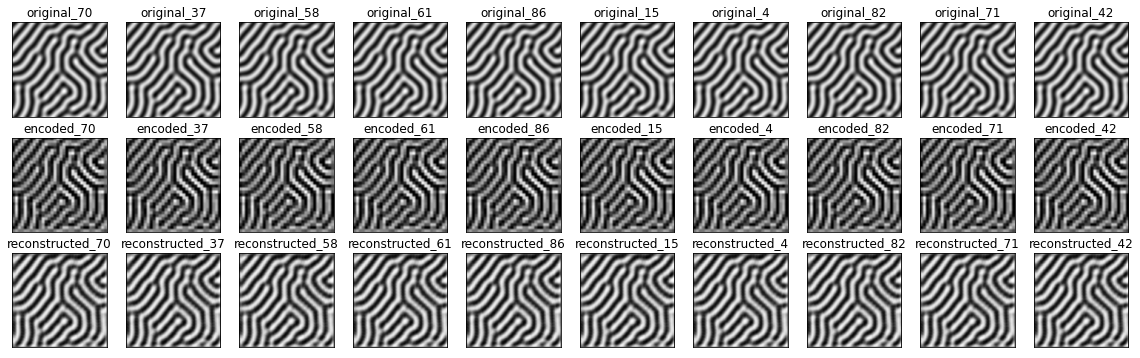

In [17]:
conv_encoded_data = conv_autoencoder.encoder(conv_u_val).numpy()
conv_decoded_data = conv_autoencoder.decoder(conv_encoded_data).numpy()

n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
  idx = np.random.randint(1,99)
  print("time step: ",idx)
  # display original
  ax = plt.subplot(3, n, i + 1)
  plt.imshow(tf.squeeze(conv_u_val[i]))
  plt.title("original"+"_"+str(idx))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # # display reshaped encoded
  ax = plt.subplot(3, n, i + 1+n)
  plt.imshow(tf.squeeze(conv_encoded_data[i].reshape(32,32)))
  plt.title("encoded"+"_"+str(idx))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(3, n, i + 1 + 2*n)
  plt.imshow(conv_decoded_data[i][:,:,0])
  plt.title("reconstructed"+"_"+str(idx))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)